In [118]:
# 基于py3.10
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight,compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn import  metrics
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import regularizers
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.over_sampling import SMOTE

In [252]:
# 导入数据
data = pd.read_csv(r"D:/Code_Project/fc_Project/data.csv",encoding="gbk")

In [253]:
# 观察数据
data

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,3.521200e+14,0,6,7,5.666667,3,2.166667,34,7,5.666667,...,0.939194,4.262371e-03,0.050817,0.0,0.007434,0.0,0,0,1,0
1,3.521200e+14,0,6,4,2.500000,2,1.333333,15,4,2.500000,...,0.955626,2.981609e-03,0.030815,0.0,0.013398,0.0,0,0,1,0
2,3.521200e+14,8,6,8,6.166667,3,2.166667,45,9,7.500000,...,0.783610,3.321330e-04,0.000000,0.0,0.195087,0.0,0,0,0,0
3,3.521200e+14,0,6,6,3.666667,2,1.833333,23,6,3.833333,...,0.458649,1.843500e-04,0.000000,0.0,0.541351,0.0,0,0,0,0
4,3.521200e+14,0,6,5,4.333333,1,1.000000,26,5,4.333333,...,0.983726,3.163870e-04,0.000000,0.0,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,3.521280e+14,0,6,8,6.500000,3,3.000000,40,8,6.666667,...,0.986674,5.260850e-04,0.000000,0.0,0.013326,0.0,0,0,1,0
15996,3.521280e+14,0,6,8,6.833333,2,2.000000,42,9,7.000000,...,0.927005,6.890000e-05,0.008665,0.0,0.039553,0.0,1,0,0,0
15997,3.521280e+14,4,6,8,6.333333,2,2.000000,42,9,7.000000,...,0.773433,6.738972e-03,0.002232,1.0,0.223888,0.0,0,0,1,0
15998,3.521280e+14,0,6,5,3.333333,1,1.000000,20,5,3.333333,...,0.967045,7.680000e-07,0.025627,0.0,0.006425,0.0,0,0,0,0


In [254]:
# 删除脱敏且没有意义的列
Desensitized_meaningless_list = [
    '个人编码',
    '顺序号_NN',
    '交易时间DD_NN',
    '交易时间YYYY_NN',
    '交易时间YYYYMM_NN',
]
data = data.drop(Desensitized_meaningless_list,axis=1)

In [255]:
data.isnull().sum()
# 观察到存在缺失值的列,进行缺失值处理

一天去两家医院的天数    0
就诊的月数         0
月就诊天数_MAX     0
月就诊天数_AVG     0
月就诊医院数_MAX    0
             ..
个人支付治疗费用占比    0
BZ_民政救助       0
BZ_城乡优抚       0
是否挂号          0
RES           0
Length: 77, dtype: int64

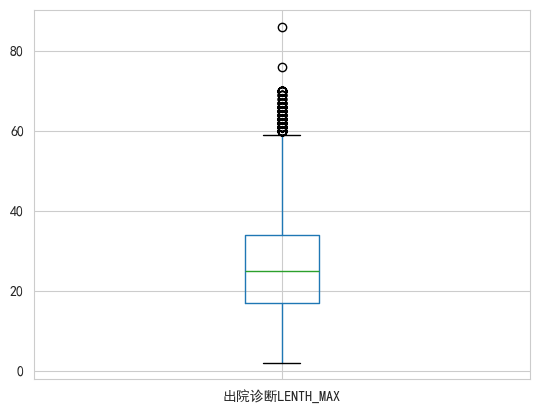

In [256]:
# 缺失值填充
emp_col = '出院诊断LENTH_MAX'
#  先观察箱图
data.boxplot(column=emp_col)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.show()

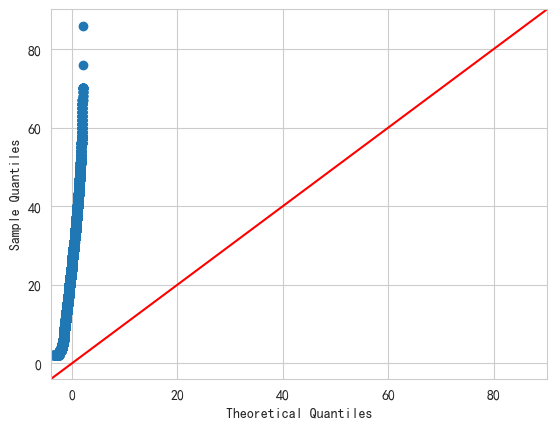

In [257]:
# 观察qq图
sm.qqplot(data[emp_col],line='45')
plt.show()
# 存在重尾情况或右偏情况，null值采用中位数进行填充

In [258]:
# 采用中位数进行数据填充
data[emp_col].fillna(np.median(data[~np.isnan(data[emp_col])]),inplace=True)
data[emp_col]

0        29.0
1        20.0
2        29.0
3        16.0
4        33.0
         ... 
15995    28.0
15996    25.0
15997    30.0
15998     5.0
15999    34.0
Name: 出院诊断LENTH_MAX, Length: 16000, dtype: float64

In [259]:
## 进行异常值处理

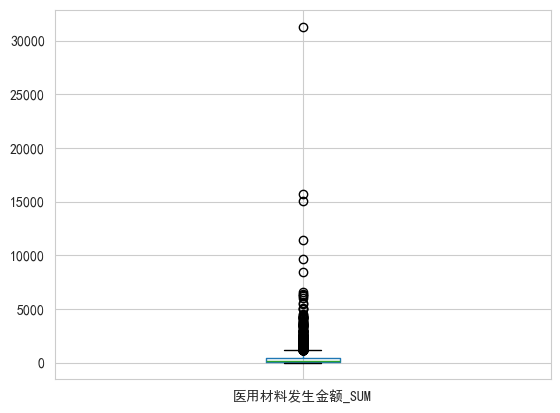

In [260]:
# 1，画箱线图
data.boxplot(column='医用材料发生金额_SUM')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.show()
# 发现多数的列呈右偏，故此处不用箱图进行异常值处理，采用缩尾处理

In [261]:
# 采用缩尾处理
for col in data.columns:
    if data[col].dtype is np.dtype('int64'):    #不对离散类型数据进行该处理
        continue
    df = data[col].tolist()
    def Winsorization_outliers(df):
        q1 = np.percentile(df,1)
        q3 = np.percentile(df,99)
        data.loc[data[col]>q3,col]=q3
        data.loc[data[col]<q1,col]=q1
    Winsorization_outliers(df=df)

In [262]:
# 删除每列只有一种值的列
for col in data.columns.tolist():
    count = len(data[col].unique())
    print(count)
    if count==1:
        data = data.drop(col,axis=1)
# 只有一列被删除

65
7
31
175
8
38
190
57
196
15414
15627
15305
15591
137
443
15595
15651
15510
15626
9
1
15293
15627
15614
15239
15588
6732
15586
4825
13383
8320
2844
124
3252
362
5420
262
4786
45
5
1
95
77
7603
1
752
16
486
8
6508
1
15182
120
1
15618
186
2127
5876
15261
15623
2144
121
1
2118
1
30
57
15677
11269
12181
1079
15676
2296
2
2
2
2


In [263]:
# 删除重复的行
data.drop_duplicates(inplace=True)

In [264]:
data

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,0,6,7,5.666667,3,2.166667,34,7,5.666667,3501.18,...,0.939194,4.262371e-03,0.050817,0.000000,0.007434,0.0,0,0,1,0
1,0,6,4,2.500000,2,1.333333,15,4,2.500000,2217.66,...,0.955626,2.981609e-03,0.030815,0.000000,0.013398,0.0,0,0,1,0
2,8,6,8,6.166667,3,2.166667,45,9,7.500000,3360.55,...,0.783610,3.321330e-04,0.000000,0.000000,0.195087,0.0,0,0,0,0
3,0,6,6,3.666667,2,1.833333,23,6,3.833333,3030.61,...,0.458649,1.843500e-04,0.000000,0.000000,0.541351,0.0,0,0,0,0
4,0,6,5,4.333333,1,1.000000,26,5,4.333333,2332.45,...,0.983726,3.163870e-04,0.000000,0.000000,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,6,8,6.500000,3,3.000000,40,8,6.666667,2831.13,...,0.986674,5.260850e-04,0.000000,0.000000,0.013326,0.0,0,0,1,0
15996,0,6,8,6.833333,2,2.000000,42,9,7.000000,2369.03,...,0.927005,6.890000e-05,0.008665,0.000000,0.039553,0.0,1,0,0,0
15997,4,6,8,6.333333,2,2.000000,42,9,7.000000,5421.56,...,0.773433,6.738972e-03,0.002232,0.147661,0.223888,0.0,0,0,1,0
15998,0,6,5,3.333333,1,1.000000,20,5,3.333333,5270.74,...,0.967045,7.680000e-07,0.025627,0.000000,0.006425,0.0,0,0,0,0


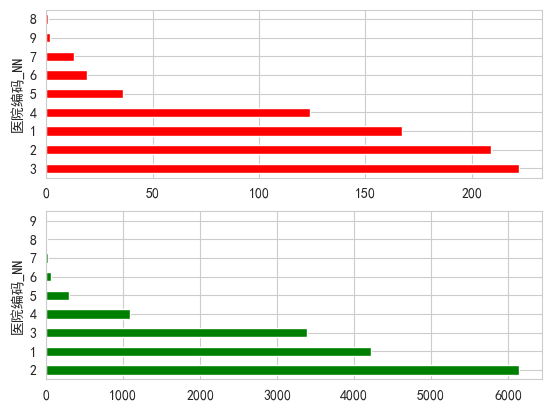

In [265]:
# 进行特征分析
col_1='医院编码_NN'
figure,ax = plt.subplots(2,1)
col_11_count = data.医院编码_NN[data['RES']==1].value_counts()
col_11_count.plot(ax=ax[0],kind='barh',color='red')
col_10_count = data.医院编码_NN[data['RES']==0].value_counts()
col_10_count.plot(kind='barh',label='0',ax=ax[1],color='green')
plt.show()
# 诈骗不同医院的就诊人数图
# 红色是欺诈（RES为1）

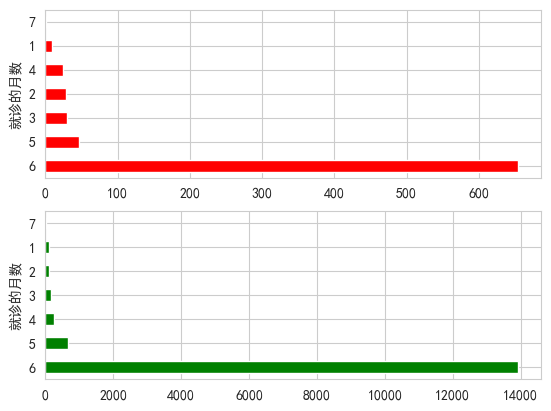

In [266]:
# 同理对就诊月数分析
col_2 = '就诊的月数'
_,ax = plt.subplots(2,1)
col_21_count = data.就诊的月数[data['RES']==1].value_counts()
col_21_count.plot(kind='barh',color='red',ax=ax[0])
col_20_count = data.就诊的月数[data['RES']==0].value_counts()
col_20_count.plot(kind='barh',color='green',ax=ax[1])
plt.show()

RES
0    15205
1      793
Name: count, dtype: int64


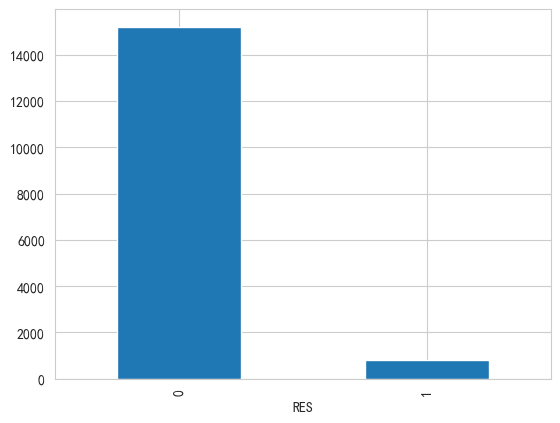

In [267]:
# 观察RES的分布情况
res_count = data["RES"].value_counts()
print(res_count)
res_count.plot(kind='bar')
plt.show()

In [268]:
## 使用筛选器法，去除高度相关的特征列（90%以上），使用皮尔逊系数
# 观察相关系数矩阵
target = 'RES'
feature = [x for x in data.columns if x not in target]
data_matrix = data[feature].corr()
plt.figure(figsize=(100, 100))
sns.heatmap(data_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

D:\anaconda3\envs\py10\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\envs\py10\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


In [269]:
data_matrix

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,出院诊断LENTH_MAX,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号
一天去两家医院的天数,1.000000,0.064557,0.472321,0.423914,0.468380,0.524468,0.641346,0.655709,0.555859,0.368918,...,0.100093,0.059427,-0.010920,-0.112283,-0.038541,0.003225,-0.042582,0.100974,-0.003004,-0.062619
就诊的月数,0.064557,1.000000,0.156867,0.154964,0.112397,0.103143,0.253809,0.131905,0.145706,0.042720,...,0.194487,0.194727,-0.013201,-0.078280,-0.044579,-0.064001,-0.009481,0.029023,0.006154,0.021309
月就诊天数_MAX,0.472321,0.156867,1.000000,0.945000,0.402466,0.429786,0.922372,0.955915,0.940435,0.511750,...,0.141875,-0.117424,0.035395,-0.164571,-0.023750,0.249556,-0.085274,0.135419,0.008534,-0.130993
月就诊天数_AVG,0.423914,0.154964,0.945000,1.000000,0.356933,0.411829,0.946284,0.887131,0.982722,0.481855,...,0.167742,-0.158437,0.026678,-0.179530,-0.024754,0.296493,-0.091404,0.137971,0.010907,-0.142443
月就诊医院数_MAX,0.468380,0.112397,0.402466,0.356933,1.000000,0.897902,0.427912,0.472335,0.432545,0.200378,...,0.133298,0.142573,-0.054039,-0.121945,-0.015824,-0.072147,-0.015599,0.086505,-0.008051,-0.139439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
治疗费用在总金额占比,0.003225,-0.064001,0.249556,0.296493,-0.072147,-0.062862,0.232376,0.198179,0.265984,0.451553,...,-0.046454,-0.856970,-0.074603,-0.154617,0.123921,1.000000,-0.049922,0.168811,0.003625,-0.054923
个人支付治疗费用占比,-0.042582,-0.009481,-0.085274,-0.091404,-0.015599,-0.023208,-0.086349,-0.080327,-0.091707,-0.017048,...,-0.035012,0.024202,0.016310,0.072298,0.076485,-0.049922,1.000000,-0.030736,-0.002284,0.075341
BZ_民政救助,0.100974,0.029023,0.135419,0.137971,0.086505,0.096494,0.144939,0.135328,0.148373,0.283552,...,0.004423,-0.083474,-0.026501,-0.141668,-0.035873,0.168811,-0.030736,1.000000,-0.009697,-0.066492
BZ_城乡优抚,-0.003004,0.006154,0.008534,0.010907,-0.008051,-0.010274,0.008982,0.005688,0.009243,0.005454,...,0.006708,-0.007086,-0.008515,0.012983,-0.005207,0.003625,-0.002284,-0.009697,1.000000,-0.007756


In [270]:
def remove_highly_correlated_columns(df, threshold=0.90):
    """
    删除高度相关的列
    """
    # 计算相关系数矩阵
    corr_matrix = df.corr().abs()

    # 找到高度相关的列
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # 删除高度相关的列
    df = df.drop(to_drop, axis=1)

    return df

In [271]:
data_del_high = remove_highly_correlated_columns(data[feature],threshold=0.9)

In [272]:
data_del_high= pd.concat([data_del_high,data[target]],axis=1)
data_del_high

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊医院数_MAX,月就诊医院数_AVG,月统筹金额_MAX,月药品金额_MAX,医院_就诊天数_MAX,医院_就诊天数_AVG,医院_统筹金_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,0,6,7,3,2.166667,3501.18,3901.45,20,11.333333,7553.00,...,0.939194,4.262371e-03,0.050817,0.000000,0.007434,0.0,0,0,1,0
1,0,6,4,2,1.333333,2217.66,2449.13,13,7.500000,9500.07,...,0.955626,2.981609e-03,0.030815,0.000000,0.013398,0.0,0,0,1,0
2,8,6,8,3,2.166667,3360.55,3302.06,23,15.000000,9161.73,...,0.783610,3.321330e-04,0.000000,0.000000,0.195087,0.0,0,0,0,0
3,0,6,6,2,1.833333,3030.61,1500.12,17,11.500000,11622.17,...,0.458649,1.843500e-04,0.000000,0.000000,0.541351,0.0,0,0,0,0
4,0,6,5,1,1.000000,2332.45,2563.26,26,26.000000,13177.89,...,0.983726,3.163870e-04,0.000000,0.000000,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,6,8,3,3.000000,2831.13,3121.72,19,13.333333,7094.15,...,0.986674,5.260850e-04,0.000000,0.000000,0.013326,0.0,0,0,1,0
15996,0,6,8,2,2.000000,2369.03,2133.65,28,21.000000,9697.88,...,0.927005,6.890000e-05,0.008665,0.000000,0.039553,0.0,1,0,0,0
15997,4,6,8,2,2.000000,5421.56,4897.23,24,21.000000,12453.45,...,0.773433,6.738972e-03,0.002232,0.147661,0.223888,0.0,0,0,1,0
15998,0,6,5,1,1.000000,5270.74,6289.22,20,20.000000,22266.53,...,0.967045,7.680000e-07,0.025627,0.000000,0.006425,0.0,0,0,0,0


In [92]:
## 进行RFR和XGBoost加权排序

In [112]:
# 进行标准化(只对连续型进行)
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
for col in data_del_high.columns:
    # if data[col].dtype is np.dtype('int64'):    #不对离散类型数据进行该处理
    #     continue
    data_del_high[col] = mm_scaler.fit_transform(data_del_high[col].values.reshape(-1, 1))

In [93]:
feature_ch = [x for x in data_del_high.columns if x not in target]
x = data_del_high[feature_ch].values
y = data_del_high[target].values

In [94]:
x

array([[ 0.,  6.,  7., ...,  0.,  0.,  1.],
       [ 0.,  6.,  4., ...,  0.,  0.,  1.],
       [ 8.,  6.,  8., ...,  0.,  0.,  0.],
       ...,
       [ 4.,  6.,  8., ...,  0.,  0.,  1.],
       [ 0.,  6.,  5., ...,  0.,  0.,  0.],
       [ 7.,  6., 13., ...,  0.,  0.,  0.]])

In [95]:
y

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 14)

In [28]:
pd.value_counts(y_train)

C:\Users\gaoxiangwei\AppData\Local\Temp\ipykernel_13104\3902155716.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_train)


0    10641
1      558
Name: count, dtype: int64

In [121]:
# Create a Contractive Autoencoder to generate synthetic fraud data
disable_eager_execution()
input_dim = x_train.shape[1]
encoding_dim = int(input_dim / 2)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# Define the Contractive loss function
def contractive_loss(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    w = 1e-4 # weight given to the jacobian regularizer
    contractive_reg = K.sum(K.square(K.gradients(y_pred, encoder)[0]), axis=1)
    return mse + w * contractive_reg

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Train the autoencoder on normal transactions
X_normal = x_train[y_train == 0]
X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.2, random_state=42)

autoencoder.compile(optimizer='adam', loss=contractive_loss,)
history = autoencoder.fit(X_normal_train, X_normal_train, epochs=100, batch_size=32, validation_data=(X_normal_test, X_normal_test))

# Generate synthetic fraud transactions using the trained autoencoder
X_fraud = x_train[y_train == 1]
synthetic_fraud = autoencoder.predict(X_fraud)

noise_factor = 0.2
encoded_normal_noisy = synthetic_fraud + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=synthetic_fraud.shape)
synthetic_fraud_data = autoencoder.predict(encoded_normal_noisy)

# Combine the synthetic fraud transactions with the original fraud transactions
X_fraud = np.vstack((X_fraud, synthetic_fraud_data))

# Combine the normal transactions with the fraud transactions
X_balanced = np.vstack((X_normal, X_fraud))
y_balanced = np.hstack((np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])))

Train on 8512 samples, validate on 2129 samples
Epoch 1/100
6976/8512 [=======================>......] - ETA: 0s - loss: 0.0698

D:\anaconda3\envs\py10\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8512/8512 [==============================] - 1s 105us/sample - loss: 0.0600 - val_loss: 0.0150
Epoch 2/100
8512/8512 [==============================] - 0s 33us/sample - loss: 0.0131 - val_loss: 0.0122
Epoch 3/100
8512/8512 [==============================] - 0s 34us/sample - loss: 0.0117 - val_loss: 0.0115
Epoch 4/100
8512/8512 [==============================] - 0s 34us/sample - loss: 0.0112 - val_loss: 0.0111
Epoch 5/100
8512/8512 [==============================] - 0s 36us/sample - loss: 0.0109 - val_loss: 0.0108
Epoch 6/100
8512/8512 [==============================] - 0s 35us/sample - loss: 0.0105 - val_loss: 0.0101
Epoch 7/100
8512/8512 [==============================] - 0s 36us/sample - loss: 0.0085 - val_loss: 0.0067
Epoch 8/100
8512/8512 [==============================] - 0s 35us/sample - loss: 0.0057 - val_loss: 0.0053
Epoch 9/100
8512/8512 [==============================] - 0s 34us/sample - loss: 0.0048 - val_loss: 0.0046
Epoch 10/100
8512/8512 [==============================] -

D:\anaconda3\envs\py10\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [130]:
pd.value_counts(y_balanced)

C:\Users\gaoxiangwei\AppData\Local\Temp\ipykernel_13928\1856131930.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_balanced)


0.0    10641
1.0     1116
Name: count, dtype: int64

In [134]:
smote = SMOTE(random_state=14)
X_train_balanced, y_train_balanced = smote.fit_resample(X_balanced, y_balanced)

In [124]:
print(res_count)

RES
0    15206
1      793
Name: count, dtype: int64


In [136]:
pd.value_counts(y_train_balanced)

C:\Users\gaoxiangwei\AppData\Local\Temp\ipykernel_13928\1362396897.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_train_balanced)


0.0    10641
1.0    10641
Name: count, dtype: int64

In [144]:
pd.value_counts(y_test)

C:\Users\gaoxiangwei\AppData\Local\Temp\ipykernel_13928\3565148537.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_test)


0.0    4565
1.0     235
Name: count, dtype: int64

In [111]:
# 先进行RF
# 观察默认情况下的效果
# 选用precision进行评估，TP/(TP+FP)
# 并使用sample_weight处理类不平衡
rf0 = RandomForestClassifier(oob_score=True, random_state=14)
sample_weight_rf00 = compute_sample_weight('balanced',
                                           y_train)
rf0.fit(x_train,y_train,sample_weight=sample_weight_rf00)
print (rf0.oob_score_)
sample_weight_rf01 = compute_sample_weight('balanced',
                                          y_test)
y_pred = rf0.predict(x_test)
print( "precision Score (Train): %f" % metrics.precision_score(y_true=y_test, y_pred=y_pred,
                                                               sample_weight=sample_weight_rf01))

0.9603536030002678
precision Score (Train): 0.988690


In [31]:
score = rf0.score(x_test, y_test)
print(score)

0.95875


In [104]:
## 进行参数优化
# 首先对n_estimators进行网格搜索
param_test1 = {'n_estimators':[x for x in range(40,80,10)]}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(oob_score=True, random_state=14,class_weight='balanced'),
                       param_grid = param_test1, scoring='f1',cv=5)
gsearch1.fit(x_train,y_train)
print( gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 70} 0.45458593351070975


In [110]:
# 接着对决策树最大深度max_depth进行网格搜索
param_test2 = {'max_depth':[x for x in range(7,15,2)]}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=70,oob_score=True,
                                                           random_state=14,class_weight='balanced'),
                        param_grid = param_test2, scoring='f1', cv=5)
gsearch2.fit(x_train,y_train)
print( gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 19} 0.46001558794222175


In [ ]:
rf1 = RandomForestClassifier(n_estimators= 76,
                             max_depth=39 ,oob_score=True,
                             random_state=14,class_weight='balanced')
rf1.fit(x_train,y_train)
print( rf1.oob_score_)
y_pred= rf1.predict(x_test)
print( "Precision Score (Train): %f" % metrics.precision_score(y_test, y_pred))

In [ ]:
# 下面再对内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf一起调参
param_test3 = {'min_samples_split':[2,3,4,6,7,8,9], 'min_samples_leaf':[1,3,4,6,7,8]}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 76, max_depth=39,
                                  oob_score=True, random_state=14,class_weight='balanced'),
   param_grid = param_test3, scoring='precision', cv=5)
gsearch3.fit(x_train,y_train)
print( gsearch3.best_params_, gsearch3.best_score_)

In [112]:
# 用搜索到的最佳参数，再看看最终的模型拟合,观察到精确率有所提高
rf2 = RandomForestClassifier(n_estimators= 76, max_depth=39, min_samples_split=2,
                                min_samples_leaf=1,oob_score=True, random_state=14)
sample_weight_rf20 = compute_sample_weight('balanced',
                                           y_train)
rf2.fit(x_train,y_train,sample_weight=sample_weight_rf20)
print (rf2.oob_score_)
sample_weight_rf2 = compute_sample_weight('balanced',
                                          y_test)
y_pred2=rf2.predict(x_test)
print( "precision Score (Train): %f" % metrics.precision_score(y_test, y_pred2,sample_weight=sample_weight_rf2))

0.9599071345655862
precision Score (Train): 0.988690


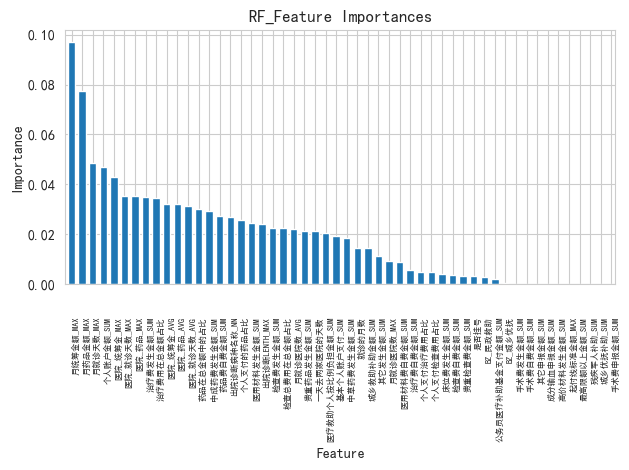

In [115]:
# 获取特征得分
rf2.fit(x,y)
_, ax = plt.subplots()
rf_importances = rf2.feature_importances_
feature_names = data_del_high.columns
sorted_indices = np.argsort(rf_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = [rf_importances[i] for i in sorted_indices]

ax.bar(range(len(sorted_importances)),sorted_importances,align='center',width=0.7)
ax.set_title("RF_Feature Importances")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
ax.set_xticks(range(len(sorted_feature_names)))
ax.set_xticklabels(sorted_feature_names, rotation=90, ha='right',rotation_mode='anchor',fontsize=6)
ax.tick_params(axis='x', pad=20)
ax.set_xlim(-0.6, len(sorted_feature_names) - 0.6)
plt.tight_layout()
plt.show()

In [114]:
feature_importance_df = pd.DataFrame({
    'Feature': sorted_feature_names,
    'rf_score': range(len(sorted_importances),0,-1),
    'Importance': sorted_importances
})
y_pre = rf2.predict(x)
print( "f1 Score (All): %f" % metrics.f1_score(y, y_pre))
feature_importance_df

f1 Score (All): 0.998105


,Feature,rf_score,Importance
0,月统筹金额_MAX,52,0.096872
1,月药品金额_MAX,51,0.077426
2,月就诊天数_MAX,50,0.048745
3,个人账户金额_SUM,49,0.047108
4,医院_统筹金_MAX,48,0.042950
5,医院_就诊天数_MAX,47,0.035351
6,医院_药品_MAX,46,0.035271
7,治疗费发生金额_SUM,45,0.034791
8,治疗费用在总金额占比,44,0.034562
9,医院_统筹金_AVG,43,0.032218


In [207]:
importance_rf_df=feature_importance_df

[[4539   26]
 [ 157   78]]


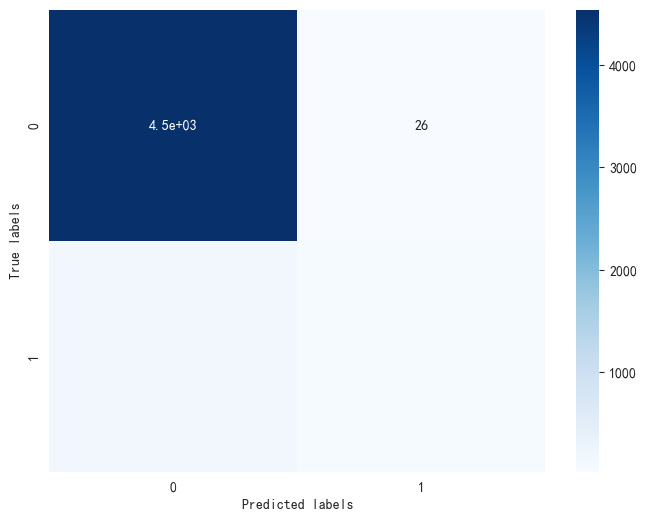

	预测结果评价报表：
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4565
           1       0.75      0.33      0.46       235

    accuracy                           0.96      4800
   macro avg       0.86      0.66      0.72      4800
weighted avg       0.96      0.96      0.95      4800



In [196]:
xgb0 = XGBClassifier()
xgb0.fit(x_train,y_train)
test_predict = xgb0.predict(x_test)
confusion_matrix_result = metrics.confusion_matrix(y_pred=test_predict,y_true=y_test)
print(confusion_matrix_result)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print("\t预测结果评价报表：\n", metrics.classification_report(y_true=y_test,y_pred=test_predict))

In [161]:
# n_estimators调参
param_xgb_test1 = {'n_estimators':[i for i in range(20,90,10)]
                   }
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 max_depth=5,
                                                 max_delta_step=1,
                                                 min_child_weight=1,
                                                 gamma=0,
                                                 subsample=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test1,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('max_depth_min_child_weight')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

max_depth_min_child_weight
gsearch1.best_params_ {'n_estimators': 50}
gsearch1.best_score_ 0.7950899831536525


In [162]:
# max_depth和min_child_weight参数调优
# max_depth和min_child_weight参数对最终结果有很大的影响。max_depth通常在3-10之间，min_child_weight。采用grid search，我们先大
# 范围地粗略参数，然后再小范围的微调。
param_xgb_test2 = {'max_depth':[i for i in range(3,10,1)],
                   'min_child_weight':[i for i in range(1,8,1)]
                   }
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=50,
                                                 max_depth=5,
                                                 max_delta_step=1,
                                                 min_child_weight=1,
                                                 gamma=0,
                                                 subsample=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test2,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('max_depth_min_child_weight')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

max_depth_min_child_weight
gsearch1.best_params_ {'max_depth': 4, 'min_child_weight': 5}
gsearch1.best_score_ 0.8072111801242234


In [163]:
# gamma参数调优
param_xgb_test3 = {'gamma':[i/10.0 for i in range(0,10)]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=50,
                                                 max_depth=4,
                                                 max_delta_step=1,
                                                 min_child_weight=5,
                                                 subsample=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test3,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('gamma')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

gamma
gsearch1.best_params_ {'gamma': 0.4}
gsearch1.best_score_ 0.8160700979667153


In [164]:
# 调整subsample参数
param_xgb_test4 = {'subsample':[i/10.0 for i in range(2,10)],
                   }
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=50,
                                                 max_depth=4,
                                                 max_delta_step=1,
                                                 min_child_weight=5,
                                                 gamma=0.4,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test4,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('subsample')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

subsample
gsearch1.best_params_ {'subsample': 0.8}
gsearch1.best_score_ 0.8160700979667153


In [166]:
param_xgb_test5 = {'max_delta_step':[x for x in range(0,2,1)]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=50,
                                                 max_depth=4,
                                                 min_child_weight=5,
                                                 subsample=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test5,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('max_delta_step')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

max_delta_step
gsearch1.best_params_ {'max_delta_step': 1}
gsearch1.best_score_ 0.8072111801242234


In [167]:
#正则化参数调优reg_alpha
param_xgb_test6 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=50,
                                                 max_depth=4,
                                                 min_child_weight=5,
                                                 max_delta_step=1,
                                                 subsample=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test6,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('reg_alpha')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

reg_alpha
gsearch1.best_params_ {'reg_alpha': 0.01}
gsearch1.best_score_ 0.808913307783798


The precision of the XGBClassifier is: 0.9111111111111111
[[4557    8]
 [ 153   82]]


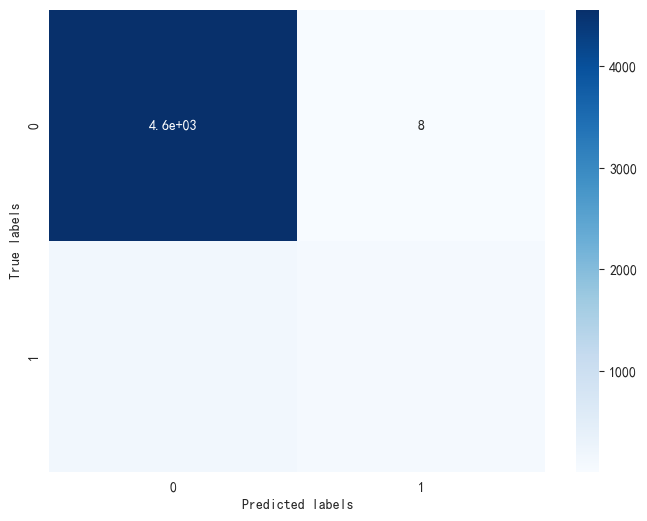

	预测结果评价报表：
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      4565
           1       0.91      0.35      0.50       235

    accuracy                           0.97      4800
   macro avg       0.94      0.67      0.74      4800
weighted avg       0.96      0.97      0.96      4800



In [174]:
xgb1=XGBClassifier(learning_rate =0.1,
                   n_estimators=50,
                   max_depth=4,
                   min_child_weight=5,
                   reg_alpha=0.01,
                   max_delta_step=1,
                   subsample=0.5,
                   objective= 'binary:logistic',
                   nthread=4,
                   seed=14)
xgb1.fit(x,y)
test_predict1 = xgb1.predict(x_test)
print('The precision of the XGBClassifier is:',metrics.precision_score(y_true=y_test,y_pred=test_predict1))
confusion_matrix_result1 = metrics.confusion_matrix(y_pred=test_predict1,y_true=y_test)
print(confusion_matrix_result1)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result1, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print("\t预测结果评价报表：\n", metrics.classification_report(y_test,test_predict1))

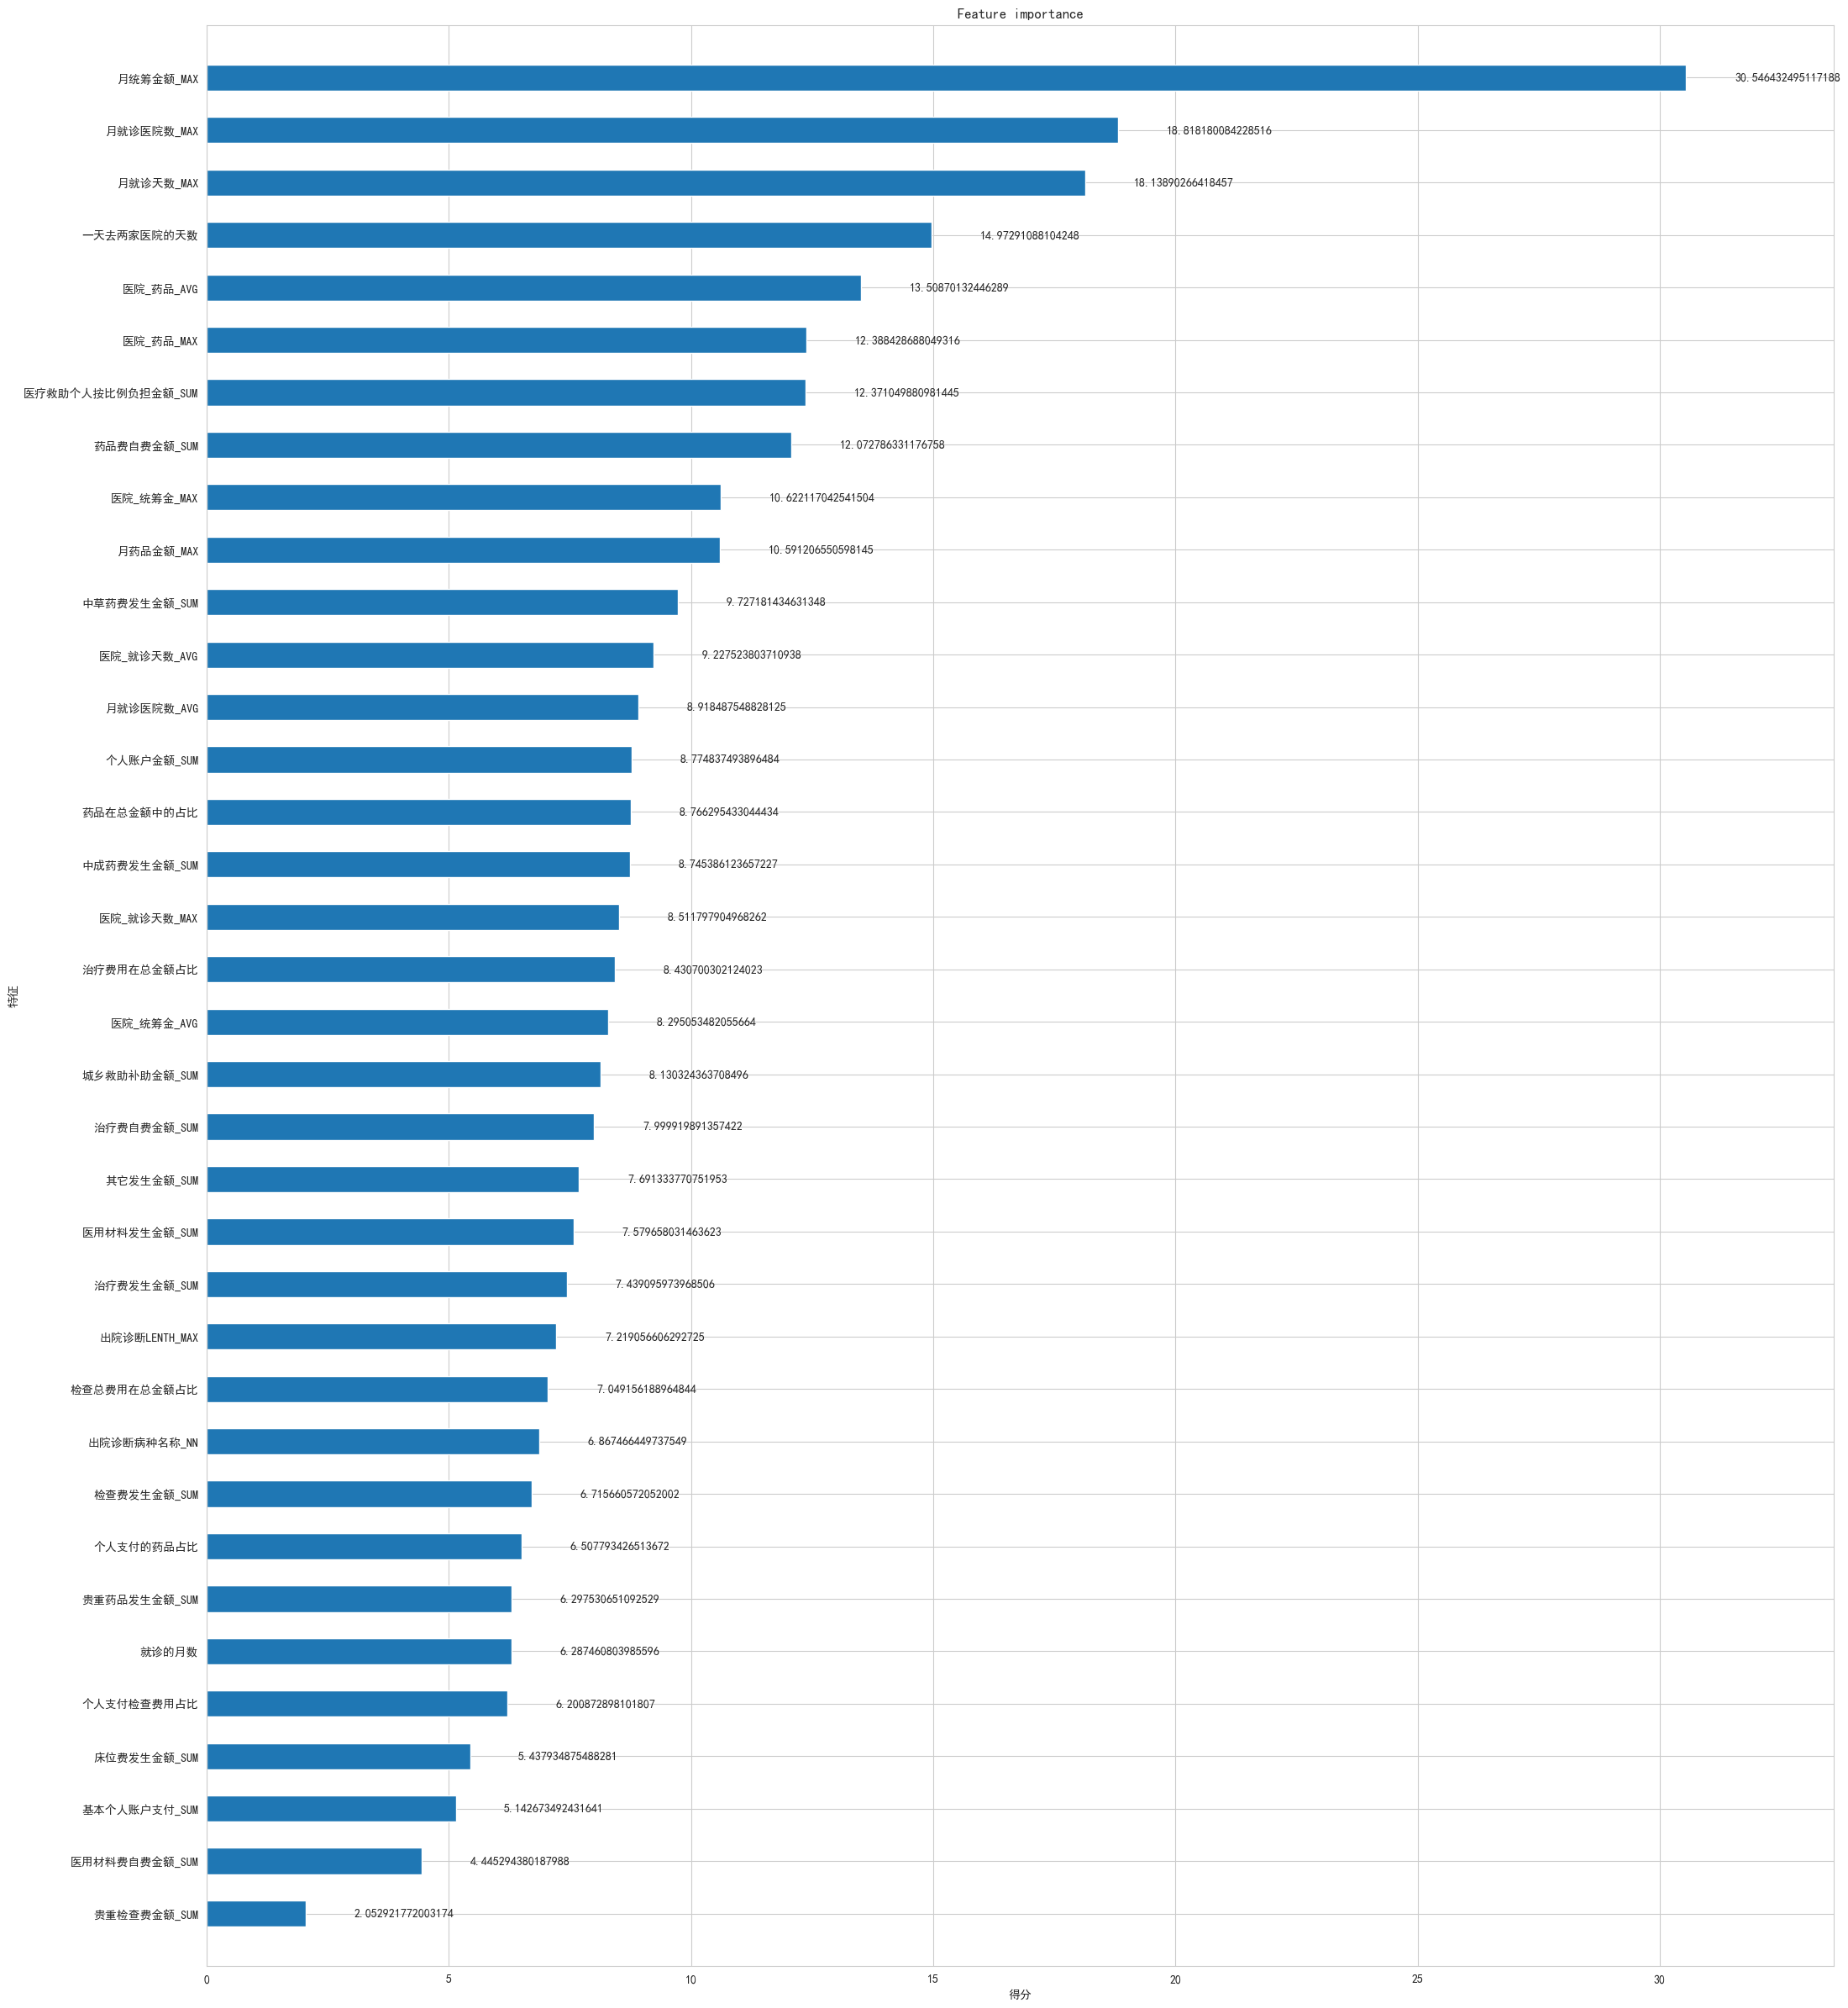

In [182]:
xgb1.get_booster().feature_names = list(data_del_high.columns)[:-1]
_,ax = plt.subplots(figsize=(25,30))
plot_importance(xgb1,importance_type='gain',ax=ax,height=0.5,xlabel='得分',ylabel='特征')
plt.show()

In [216]:
# 获取xgb的特征得分并进行minmax变化
importance_xgb = xgb1.get_booster().get_score(importance_type='gain')
importance_xgb_df = pd.DataFrame(list(importance_xgb.items()))
importance_xgb_df.columns=['Feature','Importance']
mm_scaler = MinMaxScaler()
importance_xgb_df['Importance']=mm_scaler.fit_transform(np.array(importance_xgb_df['Importance']).reshape(-1,1))
importance_xgb_df.sort_values(by='Importance',inplace=True,ascending=False)

In [217]:
importance_xgb_df

,Feature,Importance
5,月统筹金额_MAX,1.000000
3,月就诊医院数_MAX,0.588389
2,月就诊天数_MAX,0.564549
0,一天去两家医院的天数,0.453436
12,医院_药品_AVG,0.402049
11,医院_药品_MAX,0.362732
26,医疗救助个人按比例负担金额_SUM,0.362122
14,药品费自费金额_SUM,0.351654
9,医院_统筹金_MAX,0.300742
6,月药品金额_MAX,0.299657


In [224]:
# 对rf的特征得分进行minmax变化
importance_rf_df["Importance"]=mm_scaler.fit_transform(np.array(importance_rf_df['Importance']).reshape(-1,1))

In [233]:
# 删除不需要的列
importance_rf_df.drop('rf_score',axis=1,inplace=True)
importance_rf_df

,Feature,Importance
0,月统筹金额_MAX,1.000000
1,月药品金额_MAX,0.799267
2,月就诊天数_MAX,0.503188
3,个人账户金额_SUM,0.486289
4,医院_统筹金_MAX,0.443374
5,医院_就诊天数_MAX,0.364926
6,医院_药品_MAX,0.364100
7,治疗费发生金额_SUM,0.359144
8,治疗费用在总金额占比,0.356778
9,医院_统筹金_AVG,0.332586


In [234]:
# 合并两个dataframe
importance_all = pd.merge(importance_rf_df,importance_xgb_df,how='outer',on='Feature')
importance_all=importance_all.fillna(0)
importance_all

,Feature,Importance_x,Importance_y
0,月统筹金额_MAX,1.000000,1.000000
1,月药品金额_MAX,0.799267,0.299657
2,月就诊天数_MAX,0.503188,0.564549
3,个人账户金额_SUM,0.486289,0.235910
4,医院_统筹金_MAX,0.443374,0.300742
5,医院_就诊天数_MAX,0.364926,0.226679
6,医院_药品_MAX,0.364100,0.362732
7,治疗费发生金额_SUM,0.359144,0.189032
8,治疗费用在总金额占比,0.356778,0.223833
9,医院_统筹金_AVG,0.332586,0.219072


In [235]:
# 将得分相加
importance_all['Importance']=importance_all['Importance_x']+importance_all['Importance_y']
importance_all

,Feature,Importance_x,Importance_y,Importance
0,月统筹金额_MAX,1.000000,1.000000,2.000000
1,月药品金额_MAX,0.799267,0.299657,1.098924
2,月就诊天数_MAX,0.503188,0.564549,1.067737
3,个人账户金额_SUM,0.486289,0.235910,0.722199
4,医院_统筹金_MAX,0.443374,0.300742,0.744116
5,医院_就诊天数_MAX,0.364926,0.226679,0.591605
6,医院_药品_MAX,0.364100,0.362732,0.726832
7,治疗费发生金额_SUM,0.359144,0.189032,0.548176
8,治疗费用在总金额占比,0.356778,0.223833,0.580610
9,医院_统筹金_AVG,0.332586,0.219072,0.551658


In [237]:
# 按照Importance进行排序
importance_all.sort_values(by='Importance',inplace=True,ascending=False)
importance_all

,Feature,Importance_x,Importance_y,Importance
0,月统筹金额_MAX,1.000000,1.000000,2.000000
1,月药品金额_MAX,0.799267,0.299657,1.098924
2,月就诊天数_MAX,0.503188,0.564549,1.067737
4,医院_统筹金_MAX,0.443374,0.300742,0.744116
10,医院_药品_AVG,0.331069,0.402049,0.733117
6,医院_药品_MAX,0.364100,0.362732,0.726832
3,个人账户金额_SUM,0.486289,0.235910,0.722199
30,月就诊医院数_MAX,0.097768,0.588389,0.686156
23,一天去两家医院的天数,0.219601,0.453436,0.673037
14,药品费自费金额_SUM,0.280471,0.351654,0.632125


In [247]:
imp_all=importance_all.iloc[0:30,:]
imp_all=imp_all.drop(['Importance_x','Importance_y'],axis=1)
imp_all=imp_all.reset_index(drop=True)
imp_all

,Feature,Importance
0,月统筹金额_MAX,2.000000
1,月药品金额_MAX,1.098924
2,月就诊天数_MAX,1.067737
3,医院_统筹金_MAX,0.744116
4,医院_药品_AVG,0.733117
5,医院_药品_MAX,0.726832
6,个人账户金额_SUM,0.722199
7,月就诊医院数_MAX,0.686156
8,一天去两家医院的天数,0.673037
9,药品费自费金额_SUM,0.632125


In [ ]:
## 对选择出来的30个特征使用relief算法